# 1. Responses collection/ inference on example data

## Example data

In [67]:
import jsonlines
import json
import numpy as np
import os
from scripts.utils import load_jsonlines

# path = '/home/minqi/code/S2RAG/data_eval/arc_challenge_processed.jsonl'
path = '/home/minqi/code/S2RAG/data_eval/popqa_longtail_w_gs.jsonl'
outpath = path.split('.jsonl')[0] + '_example.jsonl'

data = load_jsonlines(path)
# sample 100 data as example
new_data = data[:100]
print(len(new_data))
print(new_data[0])

with open(outpath, 'w') as f:
    for item in new_data:
        json.dump(item, f)
        f.write('\n')

100
{'question': "What is Henry Feilden's occupation?", 'answers': ['politician', 'political leader', 'political figure', 'polit.', 'pol'], 'prop': 'occupation', 's_wiki_title': 'Henry Feilden (Conservative politician)', 'id': 4382392, 'pop': 58, 'ctxs': [{'id': '11341299', 'title': 'Henry Feilden (Conservative politician)', 'text': ' Henry Master Feilden (21 February 1818 – 5 September 1875) was an English Conservative Party politician.', 'score': '1.6985543'}, {'id': '3064835', 'title': 'Feilden', 'text': 'Bernard Feilden (1919–2008), British conservation architect ; Bob Feilden (1917–2004), British mechanical engineer ; Gerry Feilden (1904–1981), British general and horse racing identity ; Henry Feilden (disambiguation) ; Joseph Feilden (1824–1895), British politician ; Richard Feilden (1950–2005), British architect ; William Feilden (1772–1850), British politician ', 'score': '1.5850108'}, {'id': '14189134', 'title': 'Feilden baronets', 'text': ' Henry Wemyss Feilden, second son of

## check output format

In [2]:
tasks = ['pqa', 'tqa', 'health', 'arc']
choice = 0
result_path = f'/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-{tasks[choice]}-origin.json'

with open(result_path, 'r') as f:
    result = json.load(f)

result = result['results']

print(result[0].keys())
print(result[0]['gold'])
print(result[0]['retrieval_res'])
print('='*100)
print(result[0]['retrieval_res']['retrieval_0']['pred'])

dict_keys(['prompts', 'no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs', 'all_doc_retrieval', 'all_doc_retrieval_ids', 'all_doc_retrieval_log_probs', 'retrieval_res', 'question_id', 'gold'])
['politician', 'political leader', 'political figure', 'polit.', 'pol']
{'retrieval_0': {'pred': ' According to the text, Henry Feilden was a Conservative politician.', 'score': 0.9677050011500425, 'id_log_probs': [-1.7165990357170813e-05, -0.021438410505652428, -2.3841855067985307e-07, -5.006777428206988e-06, -0.2196231633424759, -0.006808179430663586, -5.483612312673358e-06, -0.0016095790779218078, -1.2516897186287679e-05, -5.960462772236497e-07, -0.038974545896053314, -0.06197276711463928, -0.042683664709329605, -9.536738616588991e-07, -0.04314115643501282, -0.088954396545887], 'token_ids': [29871, 7579, 304, 278, 1426, 29892, 6498, 5169, 789, 264, 471, 263, 15312, 1230, 14099, 29889, 2, 2, 2, 2], 'evidence': {'id': '11341299', 'title': 'Henry Feilden (Conservative politician)', 'text

# 2. Adaptive Retrieval Analysis on example data

This part is co-written by:

Contributors:
- Minqi Xiang (mx716@ic.ac.uk) Equally contributed
- Zihan Zhu (zcabhub@ucl.ac.uk) Equally contributed

Public Source: https://github.com/zhuzihan728/LLM_Adaptive_RAG
Private Source: https://github.com/minqi1/S2RAG

In [3]:
from scripts.metrics import *
from sklearn.metrics import accuracy_score, log_loss
import json

def adp_ret_analysis(file_name, ret_p, task, model_name, interval=0.01):
    if 'health' in file_name or 'arc' in file_name:
        metric = loose_acc
    else:
        metric = loose_match
    acc_point5 = 0
    rf_point5 = 0
    labels = []

    # load data
    res_dc = []
    with open(file_name) as f:
        original_data = json.load(f)

        if type(original_data) == list:
            res_dc = original_data
        else:
            res_dc = original_data['results']

    for data_res in res_dc:
        if metric_max_over_ground_truths(metric, data_res['no_retrieval'], data_res['gold']) > 0:
            no_ret_acc = 1
        else:
            no_ret_acc = 0
        hit = 0
        for i in range(5):
            if metric_max_over_ground_truths(metric, data_res["retrieval_res"][f'retrieval_{i}']['pred'], data_res['gold']) > 0:
                hit = 1
                break
        ret_acc = hit
        if no_ret_acc > 0:
            labels.append(0)
        else:   
            labels.append(1)
        
    draw_dc = {"retrieval threshold":[], "retrieval freq":[], "self-adaptive acc":[]}
    for thres in [round(interval*i,2) for i in range(0, int(1/interval)+1)]:
        retrieval_freq = np.sum((np.array(ret_p) - thres) > 0) / len(ret_p)
        preds = (np.array(ret_p) - thres) > 0

        selfadptive_acc = accuracy_score(labels, preds)
        if abs(thres - 0.5) < 1e-5:
            rf_point5 = round(retrieval_freq*100,1)
            print(f"thres: {thres}, retrieval_freq: {rf_point5}%, selfadptive_acc: {round(selfadptive_acc,2)}")
        draw_dc["retrieval threshold"].append(thres)
        draw_dc["retrieval freq"].append(retrieval_freq)
        draw_dc["self-adaptive acc"].append(selfadptive_acc)
    
    draw_dc_ = {}
    draw_dc_["retrieval threshold"] = draw_dc["retrieval threshold"] + draw_dc["retrieval threshold"]
    draw_dc_['metric'] = ['retrieval freq']*len(draw_dc["retrieval freq"]) + ['self-adaptive acc']*len(draw_dc["self-adaptive acc"])
    draw_dc_['value'] = draw_dc["retrieval freq"] + draw_dc["self-adaptive acc"]
    draw_dc_['title'] = [f"{model_name} on {task}"]*len(draw_dc_['value'])

    return draw_dc_

In [4]:
files_dc = {
'/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-pqa-origin.json': '/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-pqa-selfadp.json',
# '/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-arc-origin.json': '/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-arc-selfadp.json',
}

out_dcs = []
successful_judgement_2_7 = []
successful_judgement_3 = []
successful_judgement_selfrag = []

for k, v in files_dc.items():
    paths = [v]
    for ret_p_path in paths:
        with open(ret_p_path, 'r') as f:
            ret_p_file = json.load(f)
            ret_p = ret_p_file["retrieval_p"]
            ret_p_hard = ret_p_file["retrieval_p_hard"]
        path = k

        successful_judgement = ret_p_file['has_judgment']
        if 'llama2chat-' in k:
            successful_judgement_2_7.extend(successful_judgement)
            model_name = 'llama2chat'
        elif 'llama3' in k:
            successful_judgement_3.extend(successful_judgement)
            model_name = 'llama3Ins'
        else:
            successful_judgement_selfrag.extend(successful_judgement)
            model_name = 'selfrag'

        task = k.split('-')[-1].split('.')[0] # ['pqa', 'tqa', 'health', 'arc']
        print(f"processing {task}, {model_name}")
        successful_judgement_rate = np.sum(successful_judgement) / len(successful_judgement)
        print(f"successful_judgement_rate: {successful_judgement_rate}")
        out_dc = adp_ret_analysis(k, ret_p, task, model_name, interval=0.01)
        out_dcs.append(out_dc)
    # plt.show()
print('===finished===')
print("successful_judgement_2_7", np.sum(successful_judgement_2_7) / len(successful_judgement_2_7))
# print("successful_judgement_3", np.sum(successful_judgement_3) / len(successful_judgement_3))
# print("successful_judgement_selfrag", np.sum(successful_judgement_selfrag) / len(successful_judgement_selfrag))


processing origin, llama2chat
successful_judgement_rate: 1.0
thres: 0.5, retrieval_freq: 100.0%, selfadptive_acc: 0.59
===finished===
successful_judgement_2_7 1.0


Text(0.5, 0.98, 'Self-adaptive retrieval analysis')

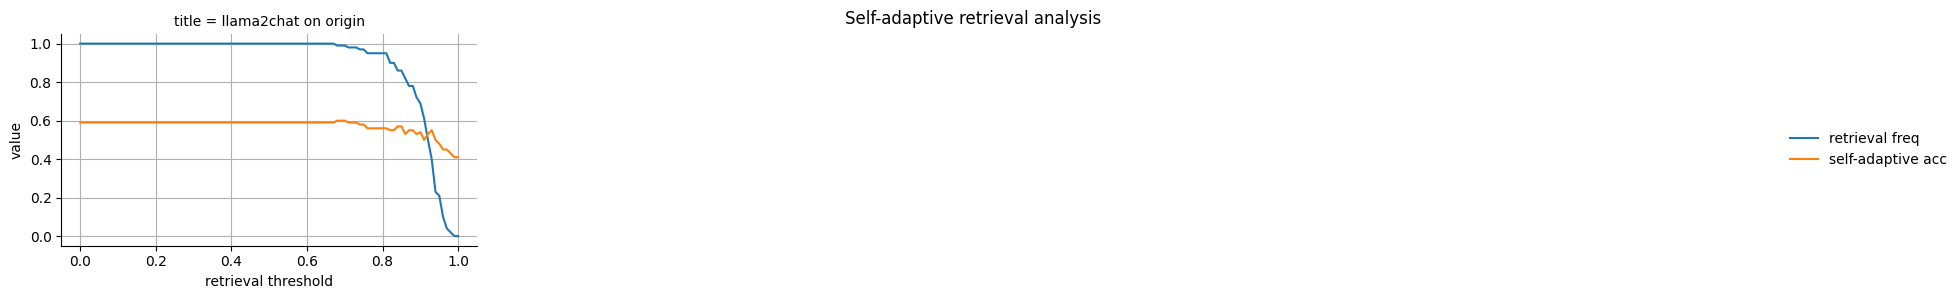

In [5]:
import pandas as pd
import seaborn as sns

final_dc = {"retrieval threshold":[], "value":[], "title":[], "metric":[]}

for dc in out_dcs:
    for k, v in dc.items():
        try:
            final_dc[k] += v
        except:
            pass

df = pd.DataFrame(final_dc)

filtered_df = df[df['metric'].isin(['self-adaptive acc', 'retrieval freq'])]

g = sns.FacetGrid(filtered_df, col="title", col_wrap=4, height=3, aspect=1.5)
g.map(sns.lineplot, "retrieval threshold", "value", hue="metric", data=df, sort=False,  errorbar=None, )

g.add_legend()

for ax in g.axes.flat:
    ax.grid(True)
    
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Self-adaptive retrieval analysis")

### change data format for later process

In [6]:

tasks = ['pqa', 'tqa', 'health', 'arc']
choice = 0

result_path = f'/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-{tasks[choice]}-origin.json'

with open(result_path, 'r') as f:
    json_file = json.load(f)
df1 = pd.DataFrame(json_file)

print(result[0].keys())
print(result[0]['gold'])
print(result[0]['retrieval_res'])
print('='*100)
print(result[0]['retrieval_res']['retrieval_0']['pred'])

dict_keys(['prompts', 'no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs', 'all_doc_retrieval', 'all_doc_retrieval_ids', 'all_doc_retrieval_log_probs', 'retrieval_res', 'question_id', 'gold'])
['politician', 'political leader', 'political figure', 'polit.', 'pol']
{'retrieval_0': {'pred': ' According to the text, Henry Feilden was a Conservative politician.', 'score': 0.9677050011500425, 'id_log_probs': [-1.7165990357170813e-05, -0.021438410505652428, -2.3841855067985307e-07, -5.006777428206988e-06, -0.2196231633424759, -0.006808179430663586, -5.483612312673358e-06, -0.0016095790779218078, -1.2516897186287679e-05, -5.960462772236497e-07, -0.038974545896053314, -0.06197276711463928, -0.042683664709329605, -9.536738616588991e-07, -0.04314115643501282, -0.088954396545887], 'token_ids': [29871, 7579, 304, 278, 1426, 29892, 6498, 5169, 789, 264, 471, 263, 15312, 1230, 14099, 29889, 2, 2, 2, 2], 'evidence': {'id': '11341299', 'title': 'Henry Feilden (Conservative politician)', 'text

In [7]:
keys = ['no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs',
       'all_doc_retrieval', 'all_doc_retrieval_ids',
       'all_doc_retrieval_log_probs', 'retrieval_res', 'question_id', 'gold',
       'question', 'ret_0', 'ret_0_log_probs', 'ret_0_ctx', 'ret_0_ctx_score',
       'ret_0_scores', 'ret_1', 'ret_1_log_probs', 'ret_1_ctx',
       'ret_1_ctx_score', 'ret_1_scores', 'ret_2', 'ret_2_log_probs',
       'ret_2_ctx', 'ret_2_ctx_score', 'ret_2_scores', 'ret_3',
       'ret_3_log_probs', 'ret_3_ctx', 'ret_3_ctx_score', 'ret_3_scores',
       'ret_4', 'ret_4_log_probs', 'ret_4_ctx', 'ret_4_ctx_score',
       'ret_4_scores']

result = {key: [] for key in keys}
for i in range(len(df1)):
    result['no_retrieval'].append(df1['results'][i]['no_retrieval'])
    result['no_retrieval_ids'].append(df1['results'][i]['no_retrieval_ids'])  
    result['no_retrieval_log_probs'].append(df1['results'][i]['no_retrieval_log_probs'])
    result['all_doc_retrieval'].append(df1['results'][i]['all_doc_retrieval'])
    result['all_doc_retrieval_ids'].append(df1['results'][i]['all_doc_retrieval_ids'])
    result['all_doc_retrieval_log_probs'].append(df1['results'][i]['all_doc_retrieval_log_probs'])
    # result['retrieval'].append(df1['results'][i]['retrieval'])
    # result['retrieval_token_ids'].append(df1['results'][i]['retrieval_token_ids'])
    # result['retrieval_log_probs'].append(df1['results'][i]['retrieval_log_probs'])
    result['retrieval_res'].append(df1['results'][i]['retrieval_res'])
    result['question_id'].append(df1['results'][i]['question_id'])
    result['gold'].append(df1['results'][i]['gold'])
    result['question'].append(df1['results'][i]['prompts']['no_retrieval'][0].replace('[INST]', '').replace('[/INST]', '').replace('<s>', '').replace('</s>', '').strip())
    
    result['ret_0'].append(df1['results'][i]['retrieval_res']['retrieval_0']['pred'])
    result['ret_0_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_0']['id_log_probs'])
    ret_0_evid = df1['results'][i]['retrieval_res']['retrieval_0']['evidence']
    result['ret_0_ctx'].append(ret_0_evid['title'] + '\n' + ret_0_evid['text'])
    result['ret_0_ctx_score'].append(ret_0_evid['score'])
    result['ret_0_scores'].append(None)
    
    result['ret_1'].append(df1['results'][i]['retrieval_res']['retrieval_1']['pred'])
    result['ret_1_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_1']['id_log_probs'])
    ret_1_evid = df1['results'][i]['retrieval_res']['retrieval_1']['evidence']
    result['ret_1_ctx'].append(ret_1_evid['title'] + '\n' + ret_1_evid['text'])
    result['ret_1_ctx_score'].append(ret_1_evid['score'])
    result['ret_1_scores'].append(None)

    result['ret_2'].append(df1['results'][i]['retrieval_res']['retrieval_2']['pred'])
    result['ret_2_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_2']['id_log_probs'])
    ret_2_evid = df1['results'][i]['retrieval_res']['retrieval_2']['evidence']
    result['ret_2_ctx'].append(ret_2_evid['title'] + '\n' + ret_2_evid['text'])
    result['ret_2_ctx_score'].append(ret_2_evid['score'])
    result['ret_2_scores'].append(None)

    result['ret_3'].append(df1['results'][i]['retrieval_res']['retrieval_3']['pred'])
    result['ret_3_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_3']['id_log_probs'])
    ret_3_evid = df1['results'][i]['retrieval_res']['retrieval_3']['evidence']
    result['ret_3_ctx'].append(ret_3_evid['title'] + '\n' + ret_3_evid['text'])
    result['ret_3_ctx_score'].append(ret_3_evid['score'])
    result['ret_3_scores'].append(None)

    result['ret_4'].append(df1['results'][i]['retrieval_res']['retrieval_4']['pred'])
    result['ret_4_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_4']['id_log_probs'])
    ret_4_evid = df1['results'][i]['retrieval_res']['retrieval_4']['evidence']
    result['ret_4_ctx'].append(ret_4_evid['title'] + '\n' + ret_4_evid['text'])
    result['ret_4_ctx_score'].append(ret_4_evid['score'])
    result['ret_4_scores'].append(None)
    
# convert dict of list to list of dict
list_of_dict = []

keys = result.keys()
length = len(result['no_retrieval'])
print(length)
for i in range(length):
    new_dict = {}
    for key in keys:
        new_dict[key] = result[key][i]
    list_of_dict.append(new_dict)

100


In [8]:
# output the results
output_path = result_path.replace('-origin.json', '.json')
with open(output_path, 'w') as f:
    json.dump(list_of_dict, f)

# 3. Confidence RAG analysis on example data

In [9]:
# simple calculation on the accuracy
import json
import pandas as pd
model = 'llama2-7b' # 'llama2-7b' or 'llama3-8b'
choice = 0

tasks = ['pqa', 'tqa', 'health', 'arc']
if 'llama2' in model and '7' in model:
    path = f'/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif 'llama3' in model:
    path = f'/home/minqi/code/S2RAG/minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'selfrag' in model:
    path = f'/home/minqi/code/S2RAG/minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(path) as f:
    json_file = json.load(f)

df = pd.DataFrame(json_file)

metrics

In [10]:
def compute_confidence(log_probs):
    '''
    log_probs: List[float]
    '''
    return np.mean(np.exp(log_probs))

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']
answers = []
for item in json_file:
    cfd = [compute_confidence(item[pre + '_log_probs']) for pre in prefix] 
    max_pos = np.argmax(cfd)
    answers.append(item[prefix[max_pos]])
golds = df['gold']

scores = []
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)

print('Resuls for Confidence RAG: ', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')

Resuls for Confidence RAG:  llama2-7b pqa
loose_match 27.0


boxplot for confidence distribution

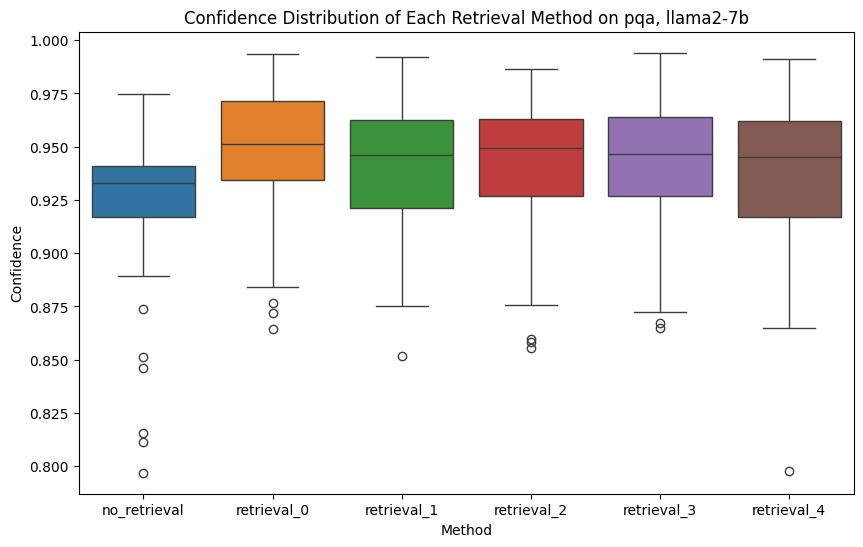

In [11]:
# confdidence distrubution of each prefix: box plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
cfd_no = []
cfd_0 = []
cfd_1 = []
cfd_2 = []
cfd_3 = []
cfd_4 = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']
answers = []
for item in json_file:
    cfd = [compute_confidence(item[pre + '_log_probs']) for pre in prefix] 
    cfd_no.append(cfd[0])
    cfd_0.append(cfd[1])
    cfd_1.append(cfd[2])
    cfd_2.append(cfd[3])
    cfd_3.append(cfd[4])
    cfd_4.append(cfd[5])

df_cfd = pd.DataFrame({'no_retrieval': cfd_no, 'retrieval_0': cfd_0, 'retrieval_1': cfd_1, 'retrieval_2': cfd_2, 'retrieval_3': cfd_3, 'retrieval_4': cfd_4})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cfd)
plt.ylabel('Confidence')
plt.xlabel('Method')
plt.title(f'Confidence Distribution of Each Retrieval Method on {tasks[choice]}, {model}')
plt.show()

# 4. Self-evaluation RAG analysis on example data

In [12]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 0

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec_SEnCFD.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec_SEnCFD.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec_SEnCFD.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

FileNotFoundError: [Errno 2] No such file or directory: 'minqi_inf_output/llama2chat-pqa-final_rec_SEnCFD.json'

metrics

In [63]:
answers = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']

for i in range(len(df['chosen_ans'])):
    cur_ans_prefix = df['chosen_ans'][i]
    cur_ans = df_aux[cur_ans_prefix][i]

    answers.append(cur_ans)

scores = []
golds = df['golds']
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)
print('Resuls for SE RAG: ', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')


Resuls for SE RAG:  llama2-7b arc
loose_acc 53.0


violin plot for SE score distribution

/tmp/ipykernel_2693346/3586489209.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Retrieval Method', y='Score', data=df_melted, palette='pastel')


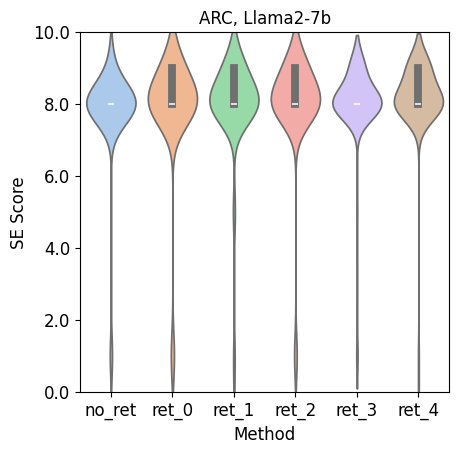

In [64]:
from matplotlib.ticker import FuncFormatter

global_record = df['global_record']
# plot the global record: plot for hist distribution of global record
def get_score(record, i):
    ret = [item[i] for item in record]
    return ret

def one_decimals(x, pos):
    return f'{x:.1f}'

df_se = pd.DataFrame({'no_ret': get_score(global_record, 0), 'ret_0': get_score(global_record, 1), 'ret_1': get_score(global_record, 2), 'ret_2': get_score(global_record, 3), 'ret_3': get_score(global_record, 4), 'ret_4': get_score(global_record, 5)})
df_melted = df_se.melt(var_name='Retrieval Method', value_name='Score')

# Plot
# Plot
plt.figure(figsize=(4.5, 4.5))
sns.violinplot(x='Retrieval Method', y='Score', data=df_melted, palette='pastel')
plt.gca().set_ylim(bottom=0, top=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(one_decimals))
plt.ylabel('SE Score', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'{tasks[choice].upper()}, {model.capitalize()}', fontsize=12)
plt.subplots_adjust(left=0.17, right=0.99, top=0.91, bottom=0.11)
plt.show()


# 5. Standard RAG (Top retrieval) + No Retrieval

In [15]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 0
chosen_ret = ['no_retrieval', 'ret_0'] # 'ret_0' or 'no_retrieval'

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

In [16]:
for chosen_ in chosen_ret:
    answers = []
    for i in range(len(df['chosen_ans'])):
        cur_ans_prefix = chosen_
        cur_ans = df_aux[cur_ans_prefix][i]
        answers.append(cur_ans)

    scores = []
    golds = df['golds']
    for i in range(len(answers)):
        if choice in [0,1]:
            metric = 'loose_match'
            score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
        else:
            metric = 'loose_acc'
            score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
        scores.append(score_)
    print(f'Resuls for {chosen_}:', model, tasks[choice])
    print(f'{metric} {np.mean(scores)*100:.1f}')
    print('='*100)


Resuls for no_retrieval: llama2-7b pqa
loose_match 41.0
Resuls for ret_0: llama2-7b pqa
loose_match 49.0


# 6. S2RAG

## Origin S2RAG

In [28]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 0

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

answers = []
generation_cnt = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']

for i in range(len(df['chosen_ans'])):
    cur_ans_prefix = df['chosen_ans'][i]
    cur_ans = df_aux[cur_ans_prefix][i]
    cur_generation = df['num_generations'][i] + df['num_generations'][i] - 2 # df['num_generations'][i] generations and df['num_generations'][i]-2 comparisons

    answers.append(cur_ans)
    generation_cnt.append(cur_generation)

scores = []
golds = df['golds']
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)
print('Resuls for S2RAG:', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')
print(f'NGPQ (number of generations per query): {np.mean(generation_cnt):.1f}')


Resuls for S2RAG: llama2-7b pqa
loose_match 47.0
NGPQ (number of generations per query): 4.6


## Ablation

### a. remove confidence evaluation

In [29]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 0

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec_rm_cfd.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec_rm_cfd.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec_rm_cfd.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

answers = []
generation_cnt = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']

for i in range(len(df['chosen_ans'])):
    cur_ans_prefix = df['chosen_ans'][i]
    cur_ans = df_aux[cur_ans_prefix][i]
    cur_generation = df['num_generations'][i] + df['num_generations'][i] - 2 # df['num_generations'][i] generations and df['num_generations'][i]-2 comparisons

    answers.append(cur_ans)
    generation_cnt.append(cur_generation)

scores = []
golds = df['golds']
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)
print('Resuls for S2RAG (rm cfd):', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')
print(f'NGPQ (number of generations per query): {np.mean(generation_cnt):.1f}')


Resuls for S2RAG (rm cfd): llama2-7b pqa
loose_match 49.0
NGPQ (number of generations per query): 5.1


### b. remove self-judgement

In [30]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 0

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec_rm_SJ.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec_rm_SJ.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec_rm_SJ.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

answers = []
generation_cnt = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']

for i in range(len(df['chosen_ans'])):
    cur_ans_prefix = df['chosen_ans'][i]
    cur_ans = df_aux[cur_ans_prefix][i]
    cur_generation = df['num_generations'][i] # df['num_generations'][i] generations

    answers.append(cur_ans)
    generation_cnt.append(cur_generation)

scores = []
golds = df['golds']
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)
print('Resuls for S2RAG (rm SJ):', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')
print(f'NGPQ (number of generations per query): {np.mean(generation_cnt):.1f}')

Resuls for S2RAG (rm SJ): llama2-7b pqa
loose_match 27.0
NGPQ (number of generations per query): 6.0


### c. remove self-voting

we can directly use previous results without running new experiments (just check the recorded score after judgement)

In [31]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 0

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

answers = []
generation_cnt = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']

for i in range(len(df['chosen_ans'])):
    if df['score_after_voting'][i] == []: # it breaks the loop before self-voting
        cur_ans_prefix = df['chosen_ans'][i]
        cur_ans = df_aux[cur_ans_prefix][i]
        cur_generation = df['num_generations'][i] + df['num_generations'][i] - 1 # df['num_generations'][i] generations and df['num_generations'][i]-1 comparisons
    else: # it breaks the loop after self-voting, find a new max score based on score after judge
        cur_max_score = max(df['score_after_judge'][i][0])
        cur_ans_prefix = prefix[df['score_after_judge'][i][0].index(cur_max_score)]
        cur_ans = df_aux[cur_ans_prefix][i]
        cur_generation = df['num_generations'][i] - 1 + df['num_generations'][i] - 2 # df['num_generations'][i]-1 generations and df['num_generations'][i]-2 comparisons 

    answers.append(cur_ans)
    generation_cnt.append(cur_generation)

scores = []
golds = df['golds']
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)
print('Resuls for S2RAG (rm SV):', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')
print(f'NGPQ (number of generations per query): {np.mean(generation_cnt):.1f}')

Resuls for S2RAG (rm SV): llama2-7b pqa
loose_match 43.0
NGPQ (number of generations per query): 4.1


## Varying tau

data are collceted by varying tau

In [ ]:
tasks = ['pqa', 'tqa', 'health', 'arc']
tau_list = [0.15, 0.45, 0.75]
for tau in tau_list:
    if model == 'llama3':
        res_path = f'minqi_inf_ablation/llama3Ins-{tasks[choice]}-final_rec_{tau}.json'
        auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
        original_path = f'minqi_inf_ablation/llama3Ins-{tasks[choice]}-final_rec_0.45.json'
    elif model == 'llama2':
        res_path = f'minqi_inf_ablation/llama2chat-{tasks[choice]}-final_rec_{tau}.json'
        auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
        original_path = f'minqi_inf_ablation/llama2chat-{tasks[choice]}-final_rec_0.45.json'

    elif model == 'selfrag':
        res_path = f'minqi_inf_ablation/selfrag-{tasks[choice]}-final_rec_{tau}.json'
        auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'
        original_path = f'minqi_inf_ablation/selfrag-{tasks[choice]}-final_rec_0.45.json'


    with open(res_path) as f:
        json_file = json.load(f)

    with open(auxilary_path) as f:
        json_file_aux = json.load(f)

    with open(original_path) as f:
        json_file_original = json.load(f)

    df = pd.DataFrame(json_file)
    df = df['results']

    df_original = pd.DataFrame(json_file_original)
    df_original = df_original['results']

    df_aux = pd.DataFrame(json_file_aux)

    answers = []
    origin_answers = []
    total_generations = 0
    original_generations = 0
    prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']


    for i in range(len(df['chosen_ans'])):
        cur_ans = df_aux[df['chosen_ans'][i]][i]
        
        answers.append(cur_ans)
        origin_answers.append(df_aux[df_original['chosen_ans'][i]][i])
        if df['score_after_voting'][i] == []:
            total_generations += df['num_generations'][i] + df['num_generations'][i] - 1
        else:
            total_generations += df['num_generations'][i] + df['num_generations'][i] - 2
        if df_original['score_after_voting'][i] == []:
            original_generations += df_original['num_generations'][i] + df_original['num_generations'][i] - 1
        else:
            original_generations += df_original['num_generations'][i] + df_original['num_generations'][i] - 2
            
    print('AVG new generations:', total_generations / len(df['chosen_ans']), '\nAVG original generations:', original_generations / len(df['chosen_ans']))


    scores = []
    score_origin = []
    golds = df['golds']
    for i in range(len(answers)):
        if choice in [0,1]:
            metric = 'loose_match'
            score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
            score_origin_ = metric_max_over_ground_truths(loose_match, origin_answers[i], golds[i])
        else:
            metric = 'loose_acc'
            score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
            score_origin_ = metric_max_over_ground_truths(loose_acc, origin_answers[i], golds[i])
        scores.append(score_)
        score_origin.append(score_origin_)
    print('(new) Resuls for', model, tasks[choice], tau)
    print(f'{metric} {np.mean(scores)*100:.1f}')

    print('(Original) Resuls for', model, tasks[choice])
    print(f'{metric} {np.mean(score_origin)*100:.1f}')
    print('\n\n')

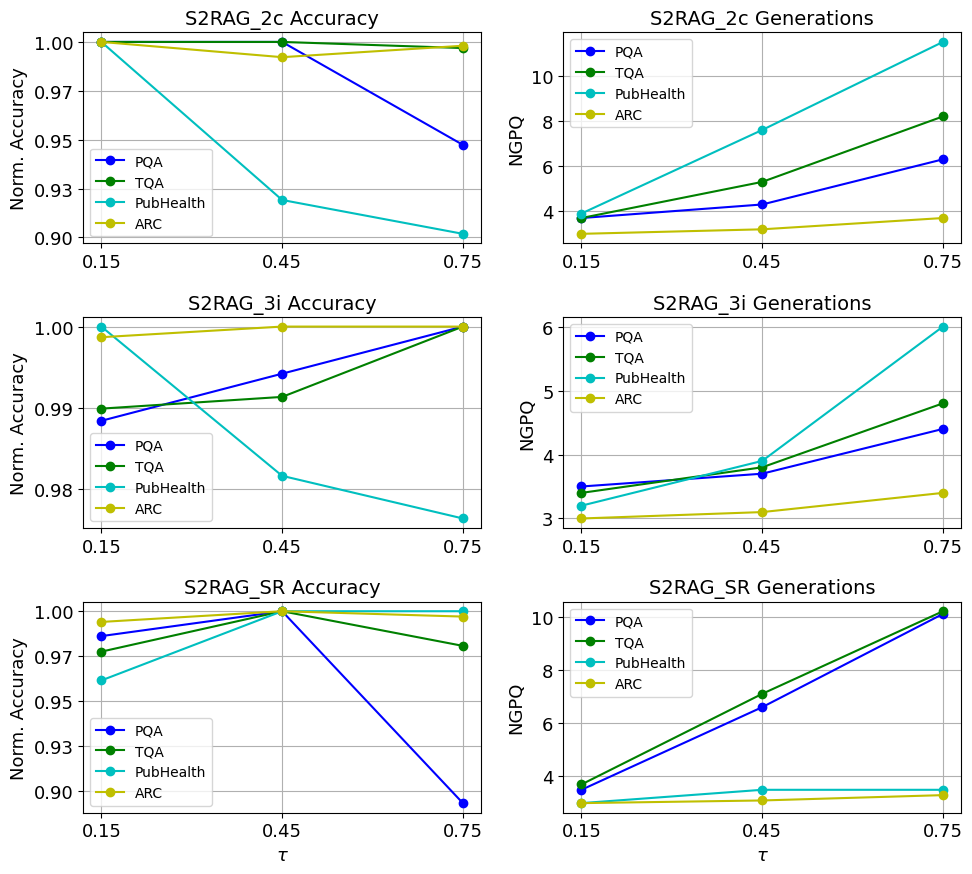

In [48]:
# plot
tasks = ['pqa', 'tqa', 'health', 'arc']
tau_list = [0.15, 0.45, 0.75]
model = ['llama2', 'llama3', 'selfrag']

# accuracy record
accuracy_pqa_llama2 = [51.3, 51.3, 48.6]
accuracy_tqa_llama2 = [63.7, 63.7, 63.5]
accuracy_health_llama2 = [69.3, 63.7, 62.5]
accuracy_arc_llama2 = [51.3, 50.9, 51.2]

accuracy_pqa_llama3 = [51.2, 51.5, 51.8]
accuracy_tqa_llama3 = [68.7, 68.8, 69.4]
accuracy_health_llama3 = [76.3, 74.9, 74.5]
accuracy_arc_llama3 = [76.4, 76.5, 76.5]

accuracy_pqa_selfrag = [50.0, 50.7, 45.3]
accuracy_tqa_selfrag = [61.0, 62.4, 61.2]
accuracy_health_selfrag = [70.1, 72.9, 72.9]
accuracy_arc_selfrag = [66.9, 67.3, 67.1]

# generation record
generation_pqa_llama2 = [3.7, 4.3, 6.3]
generation_tqa_llama2 = [3.7, 5.3, 8.2]
generation_health_llama2 = [3.9, 7.6, 11.5]
generation_arc_llama2 = [3.0, 3.2, 3.7]

generation_pqa_llama3 = [3.5, 3.7, 4.4]
generation_tqa_llama3 = [3.4, 3.8, 4.8]
generation_health_llama3 = [3.2, 3.9, 6.0]
generation_arc_llama3 = [3.0, 3.1, 3.4]

generation_pqa_selfrag = [3.5, 6.6, 10.1]
generation_tqa_selfrag = [3.7, 7.1, 10.2]
generation_health_selfrag = [3.0, 3.5, 3.5]
generation_arc_selfrag = [3.0, 3.1, 3.3]

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

tau_labels = ['0.15', '0.45', '0.75']
def one_decimal(x, pos):
    return '{:.0f}'.format(x)

def two_decimal(x, pos):
    return '{:.2f}'.format(x)
formatter = FuncFormatter(two_decimal)
formatter1 = FuncFormatter(one_decimal)

# Normalize accuracy data
def normalize(data):
    max_val = np.max(data)
    return [val / max_val for val in data]

accuracy_data = {
    'S2RAG_2c': {
        'PQA': normalize(accuracy_pqa_llama2),
        'TQA': normalize(accuracy_tqa_llama2),
        'PubHealth': normalize(accuracy_health_llama2),
        'ARC': normalize(accuracy_arc_llama2)
    },
    'S2RAG_3i': {
        'PQA': normalize(accuracy_pqa_llama3),
        'TQA': normalize(accuracy_tqa_llama3),
        'PubHealth': normalize(accuracy_health_llama3),
        'ARC': normalize(accuracy_arc_llama3)
    },
    'S2RAG_SR': {
        'PQA': normalize(accuracy_pqa_selfrag),
        'TQA': normalize(accuracy_tqa_selfrag),
        'PubHealth': normalize(accuracy_health_selfrag),
        'ARC': normalize(accuracy_arc_selfrag)
    }
}

generation_data = {
    'S2RAG_2c': {
        'PQA': generation_pqa_llama2,
        'TQA': generation_tqa_llama2,
        'PubHealth': generation_health_llama2,
        'ARC': generation_arc_llama2
    },
    'S2RAG_3i': {
        'PQA': generation_pqa_llama3,
        'TQA': generation_tqa_llama3,
        'PubHealth': generation_health_llama3,
        'ARC': generation_arc_llama3
    },
    'S2RAG_SR': {
        'PQA': generation_pqa_selfrag,
        'TQA': generation_tqa_selfrag,
        'PubHealth': generation_health_selfrag,
        'ARC': generation_arc_selfrag
    }
}

# Set the default text size for various elements
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 10

# Plotting
models = ['S2RAG_2c',  'S2RAG_3i', 'S2RAG_SR', ]
# tasks = ['pqa', 'tqa', 'health', 'arc']
tasks = ['PQA', 'TQA', 'PubHealth', 'ARC']

fig, axs = plt.subplots(len(models), 2, figsize=(10, 9))
colors = ['b', 'g', 'c', 'y']

for i, model in enumerate(models):
    # Accuracy plot
    for j, task in enumerate(tasks):
        axs[i, 0].plot(tau_list, accuracy_data[model][task], marker='o', label=task, color=colors[j % len(colors)])
    axs[i, 0].set_title(f'{model} Accuracy')
    if i == len(models) - 1:
        axs[i, 0].set_xlabel(r'$\tau$')
    axs[i, 0].set_ylabel('Norm. Accuracy')
    axs[i, 0].set_xticks(tau_list)
    axs[i, 0].set_xticklabels(tau_labels)
    axs[i, 0].yaxis.set_major_formatter(formatter)

    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # Generation plot
    for j, task in enumerate(tasks):
        axs[i, 1].plot(tau_list, generation_data[model][task], marker='o', label=task, color=colors[j % len(colors)])
    axs[i, 1].set_title(f'{model} Generations')
    if i == len(models) - 1:
        axs[i, 1].set_xlabel(r'$\tau$')
    axs[i, 1].set_ylabel('NGPQ')
    axs[i, 1].set_xticks(tau_list)
    axs[i, 1].set_xticklabels(tau_labels)
    axs[i, 1].yaxis.set_major_formatter(formatter1)

    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout()
plt.savefig('tau_performance.png')  # 保存图像
plt.show()

# 7. Training Judge

## a. Answer Pairs and Judgements Collection

In [44]:
# use existing answers for now
import json
import pandas as pd
import numpy as np
from scripts.metrics import *
import jsonlines
from scripts.utils import TASK_INST, preprocess_input_data, load_jsonlines, choose_better_prompt, \
    compute_confidence
import random

# ablation results
model = 'llama2'
choice = 3
tasks = ['pqa', 'tqa', 'health', 'arc']
task = tasks[choice]

random.seed(42)

closed = False
if choice in [2,3]:
    closed = True

is_llama3 = False
if model == 'llama3':
    ans_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
    is_llama3 = True
elif model == 'llama2':
    ans_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif model == 'selfrag':
    ans_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(ans_path) as f:
    json_file = json.load(f)

if closed:
    if task == 'arc':
        auxilliary_data_path = '/home/minqi/code/S2RAG/data_eval/arc_challenge_processed_example.jsonl' # change to real path
    elif task == 'health':
        auxilliary_data_path = '/home/minqi/code/S2RAG/data_eval/health_claims_processed_example.jsonl'
    
    auxilliary_data = load_jsonlines(auxilliary_data_path)
    auxilliary_data = preprocess_input_data(auxilliary_data, task=task, is_llama3=is_llama3)
    assert len(json_file) == len(auxilliary_data), f'Length of json file {len(json_file)} and auxilliary data {len(auxilliary_data)} do not match!'

df = pd.DataFrame(json_file)

df.keys()

Index(['no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs',
       'all_doc_retrieval', 'all_doc_retrieval_ids',
       'all_doc_retrieval_log_probs', 'retrieval_res', 'question_id', 'gold',
       'question', 'ret_0', 'ret_0_log_probs', 'ret_0_ctx', 'ret_0_ctx_score',
       'ret_0_scores', 'ret_1', 'ret_1_log_probs', 'ret_1_ctx',
       'ret_1_ctx_score', 'ret_1_scores', 'ret_2', 'ret_2_log_probs',
       'ret_2_ctx', 'ret_2_ctx_score', 'ret_2_scores', 'ret_3',
       'ret_3_log_probs', 'ret_3_ctx', 'ret_3_ctx_score', 'ret_3_scores',
       'ret_4', 'ret_4_log_probs', 'ret_4_ctx', 'ret_4_ctx_score',
       'ret_4_scores'],
      dtype='object')

In [45]:
opt1_data = [] # correct + incorrect dict(instruction, output) 
opt2_data = [] # incorrect + correct
opt3_data = [] # corect + correct
opt4_data = [] # incorrect + incorrect

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']
# random sample: 75% training, 25% test
sample_times = 2 # sample time for 4 options

for i in range(len(df)):
    # random sample 75% training, 25% test
    if random.random() < 0.25: # test
        continue # skip
    # training
    if closed:
        cur_question = auxilliary_data[i]['instruction']
    else:
        cur_question = df['question'][i]
    
    # check whether there is correct answer
    cur_answers = [df[prefix[j]][i] for j in range(len(prefix))] # 6 options
    corr_ans = [] # (ctx, str, cfd)
    incorrect_ans = []
    for ii in range(len(cur_answers)):
        if choice in [0, 1]:
            metric = 'loose_match'
            score_ = metric_max_over_ground_truths(loose_match, cur_answers[ii], df['gold'][i])    
        else:
            metric = 'loose_acc'
            score_ = metric_max_over_ground_truths(loose_acc, cur_answers[ii], df['gold'][i])
        
        if score_ == 1:
            if ii > 0:
                corr_ans.append((df[prefix[ii]+'_ctx'][i], cur_answers[ii], compute_confidence(df[prefix[ii]+'_log_probs'][i])))
            else:
                corr_ans.append((' ', cur_answers[ii], compute_confidence(df[prefix[ii]+'_log_probs'][i])))
        else:
            if ii > 0:
                incorrect_ans.append((df[prefix[ii]+'_ctx'][i], cur_answers[ii], compute_confidence(df[prefix[ii]+'_log_probs'][i])))
            else:
                incorrect_ans.append((' ', cur_answers[ii], compute_confidence(df[prefix[ii]+'_log_probs'][i])))

    # expand dataset
    if len(corr_ans) > 0 and len(incorrect_ans) > 0:
        # opt1: correct + incorrect
        for _ in range(sample_times):
            rand_corr = random.sample(corr_ans, 1)[0]
            rand_incorr = random.sample(incorrect_ans, 1)[0]
            cur_ctx = rand_corr[0] + '\n' + rand_incorr[0]
            cur_instruction = choose_better_prompt(cur_ctx, rand_corr[1], rand_corr[2], rand_incorr[1], rand_incorr[2], cur_question)
            cur_output = '1'
            opt1_data.append({'instruction': cur_instruction, 'output': cur_output, 'question': cur_question, 'gold': df['gold'][i], 'data_idx': i, 'task': task})   
        # opt2: incorrect + correct
        for _ in range(sample_times):
            rand_corr = random.sample(corr_ans, 1)[0]
            rand_incorr = random.sample(incorrect_ans, 1)[0]
            cur_ctx = rand_incorr[0] + '\n' + rand_corr[0]
            cur_instruction = choose_better_prompt(cur_ctx, rand_incorr[1], rand_incorr[2], rand_corr[1], rand_corr[2], cur_question)
            cur_output = '2'
            opt2_data.append({'instruction': cur_instruction, 'output': cur_output, 'question': cur_question, 'gold': df['gold'][i], 'data_idx': i, 'task': task})
    if len(corr_ans) > 1:
        # opt3: correct + correct
        for _ in range(sample_times):
            rand_corr = random.sample(corr_ans, 2)
            cur_ctx = rand_corr[0][0] + '\n' + rand_corr[1][0]
            cur_instruction = choose_better_prompt(cur_ctx, rand_corr[0][1], rand_corr[0][2], rand_corr[1][1], rand_corr[1][2], cur_question)
            cur_output = '3'
            opt3_data.append({'instruction': cur_instruction, 'output': cur_output, 'question': cur_question, 'gold': df['gold'][i], 'data_idx': i, 'task': task})
    if len(incorrect_ans) > 1:
        # opt4: incorrect + incorrect
        for _ in range(sample_times):
            rand_incorr = random.sample(incorrect_ans, 2)
            cur_ctx = rand_incorr[0][0] + '\n' + rand_incorr[1][0]
            cur_instruction = choose_better_prompt(cur_ctx, rand_incorr[0][1], rand_incorr[0][2], rand_incorr[1][1], rand_incorr[1][2], cur_question)
            cur_output = '4'
            opt4_data.append({'instruction': cur_instruction, 'output': cur_output, 'question': cur_question, 'gold': df['gold'][i], 'data_idx': i, 'task': task})
   
print(len(opt1_data), len(opt2_data), len(opt3_data), len(opt4_data))


52 52 88 96


In [46]:
# write to jsonl
# sample to avg number
import os
avg_sample = int(np.mean([len(opt1_data), len(opt2_data), len(opt3_data), len(opt4_data)]))
print("Sample to avg number:", avg_sample)

opt1_data = random.choices(opt1_data, k=avg_sample)
opt2_data = random.choices(opt2_data, k=avg_sample)
opt3_data = random.choices(opt3_data, k=avg_sample)
opt4_data = random.choices(opt4_data, k=avg_sample)
print (len(opt1_data), len(opt2_data), len(opt3_data), len(opt4_data))

import jsonlines
writing_path =  os.getcwd()
with jsonlines.open(f'{writing_path}/data_training/train_data_{task}_example.jsonl', 'w') as writer:
    for data in opt1_data + opt2_data + opt3_data + opt4_data:
        writer.write(data)


Sample to avg number: 72
72 72 72 72


mix all data

In [47]:
import jsonlines
import random
from collections import defaultdict

# Define paths and tasks
writing_path =  os.getcwd()
# mix_tasks = ['pqa', 'tqa', 'health', 'arc']
mix_tasks = ['arc'] # we only use arc for illustration purpose 

files = [f'{writing_path}/data_training/train_data_{task}_example.jsonl' for task in mix_tasks]

# Read and store all data
all_data = defaultdict(list)
for file, task in zip(files, mix_tasks):
    with jsonlines.open(file) as reader:
        for obj in reader:
            all_data[task].append(obj)

# Upsample or downsample each task to match the minimum size
balanced_data = []
for task, data in all_data.items():
    balanced_data.extend(data)

# Shuffle the balanced data to mix different tasks
random.shuffle(balanced_data)

# Write to the final JSONL file
output_file = f'{writing_path}/data_training/train_data_fusion_example.jsonl'
with jsonlines.open(output_file, mode='w') as writer:
    for obj in balanced_data:
        writer.write(obj)

print(f"All files have been combined into {output_file}")


All files have been combined into /home/minqi/code/S2RAG/data_training/train_data_fusion_example.jsonl


## b. Judgement Explanations Collection

use llama2 to collect explanations for example data

In [60]:
final_path = f'{writing_path}/data_training/train_data_fusion_example.jsonl'
final_data = load_jsonlines(final_path)
df_final = pd.DataFrame(final_data)
print('size: ', len(final_data))
df_final.head()

size:  288


,instruction,output,question,gold,data_idx,task,new_instruction
0,"Given a question and two possible answers, you...",2,Gases can be easily compressed and are able to...,[C],95,arc,"Given a question and two possible answers, you..."
1,"Given a question and two possible answers, you...",4,The period of rotation for each planet in our ...,[A],85,arc,"Given a question and two possible answers, you..."
2,"Given a question and two possible answers, you...",4,Which of the following statements is a scienti...,[D],87,arc,"Given a question and two possible answers, you..."
3,"Given a question and two possible answers, you...",2,Which of the following traits is most influenc...,[A],58,arc,"Given a question and two possible answers, you..."
4,"Given a question and two possible answers, you...",4,What is the primary cause of rainstorms?,[A],69,arc,"Given a question and two possible answers, you..."


In [61]:
# produce prompt to collect explanations for each judgement
new_instruction_lst = []
for i in range(len(df_final)):
    instruction = df_final['instruction'][i]
    output = df_final['output'][i]
    gold = df_final['gold'][i]
    new_instruction = instruction + f'\nGold answer:\n{gold}\nJudgement: \n{output}\nExplanation: \n'
    # write to new instruction
    new_instruction_lst.append(new_instruction)

df_final['new_instruction'] = new_instruction_lst
# write to jsonl
with jsonlines.open(final_path, 'w') as writer:
    for data in df_final.to_dict(orient='records'):
        writer.write(data)

In [62]:
print(df_final['new_instruction'][0])

Given a question and two possible answers, you need to determine which answer is better, equally good or equally bad. 
Some context is provided, but please note that this context might be irrelevant or misleading (sourced from similar names): 
 
Irreversible process
opened, and the gas fills the whole container. The internal energy of the gas remains the same, while the volume increases. The original state cannot be recovered by simply compressing the gas to its original volume, since the internal energy will be increased by this compression. The original state can only be recovered by then cooling the re-compressed system, and thereby irreversibly heating the environment. The diagram to the right applies only if the first expansion is "free" (Joule expansion). i.e. there can be no atmospheric pressure outside the cylinder and no weight lifted. The difference between reversible and irreversible

    
    The good answer should be concise, factual, correct and strictly follow the answer

full-size data which llama3 is used to collect explanation

In [63]:
final_path = f'{writing_path}/data_training/train_data_fusion.jsonl'
final_data = load_jsonlines(final_path)
df_final = pd.DataFrame(final_data)
print('size: ', len(final_data))
df_final.head()

size:  42072


,instruction,output,question,gold,data_idx,task,new_instruction
0,"Given a question and two possible answers, you...",1,Which character is known as Ursinho Puff in Po...,"[winnie pooh tv series, Winnie-The-Pooh, Winni...",9948,tqa,"Given a question and two possible answers, you..."
1,"Given a question and two possible answers, you...",4,Who was the oldest man to play test cricket fo...,"[Wilfred Rhodes, w rhodes, Wilf Rhodes, Wilfre...",10455,tqa,"Given a question and two possible answers, you..."
2,"Given a question and two possible answers, you...",3,What country lost the highest % of its populat...,"[Polish state, Pole land, polija, Polska, pols...",5566,tqa,"Given a question and two possible answers, you..."
3,"Given a question and two possible answers, you...",1,"""Under what name did Mrs. Middleton Murray pub...","[Kathleen Mansfield Beauchamp, Katherine Mansf...",5255,tqa,"Given a question and two possible answers, you..."
4,"Given a question and two possible answers, you...",2,Who played the title role in the 1951 film ‘Ca...,"[Greg Peck, Eldred Gregory Peck, Gregory Peckk...",1728,tqa,"Given a question and two possible answers, you..."


## c. Train data preparation

data collected for example data using llama2 (illustration purpose only)

In [65]:
train_file_path = f'{writing_path}/data_training/train_data_fusion_w_exp_example.json'
# train_data = load_jsonlines(train_file_path)
with open(train_file_path, 'w') as f:
    for data in final_data:
        f.write(json.dumps(data) + '\n')

df_train = pd.DataFrame(train_data)
print(len(df_train))
df_train.head()

40749


,instruction,output
0,"Given a question and two possible answers, you...",1\nExplanation: Answer 1 is the correct answer...
1,"Given a question and two possible answers, you...",2\nExplanation: The answer 2 is better because...
2,"Given a question and two possible answers, you...",4\nExplanation: The answers do not directly ad...
3,"Given a question and two possible answers, you...","3\nExplanation: Both answers are correct, and ..."
4,"Given a question and two possible answers, you...",4\nExplanation: Both answers are wrong since t...


In [66]:
print('TRAIN INSTRUCTION EXAMPLE:')
print(df_train['instruction'][0])
print('='*100)
print('TRAIN TARGET EXAMPLE:')
print(df_train['output'][0])

TRAIN INSTRUCTION EXAMPLE:
Given a question and two possible answers, you need to determine which answer is better, equally good or equally bad. 
Some context is provided, but please note that this context might be irrelevant or misleading (sourced from similar names): 
Geographical feature
ponds, parks and woods, mills, manor houses, moats, and churches may be considered part of a settlement. Engineered geographic features include highways, bridges, airports, railroads, buildings, dams, and reservoirs, and are part of the anthroposphere because they are man-made geographic features. Cartographic features are types of abstract geographical features, which appear on maps but not on the planet itself, even though they are located on the planet. For example, the Equator is shown on maps of the Earth, but it does not physically exist. It is a theoretical line used for reference, navigation, and measurement. Geographical feature Geographical features are
Karain semi-continent
Karain semi-co

full-size data used for judge training (llama3)

In [56]:
train_file_path = f'{writing_path}/data_training/train_data_fusion_w_exp.jsonl'
train_data = load_jsonlines(train_file_path)

df_train = pd.DataFrame(train_data)
print(len(df_train))
df_train.head()

40749


,instruction,output
0,"Given a question and two possible answers, you...",1\nExplanation: Answer 1 is the correct answer...
1,"Given a question and two possible answers, you...",2\nExplanation: The answer 2 is better because...
2,"Given a question and two possible answers, you...",4\nExplanation: The answers do not directly ad...
3,"Given a question and two possible answers, you...","3\nExplanation: Both answers are correct, and ..."
4,"Given a question and two possible answers, you...",4\nExplanation: Both answers are wrong since t...


In [58]:
print('TRAIN INSTRUCTION EXAMPLE:')
print(df_train['instruction'][0])
print('='*100)
print('TRAIN TARGET EXAMPLE:')
print(df_train['output'][0])

TRAIN INSTRUCTION EXAMPLE:
Given a question and two possible answers, you need to determine which answer is better, equally good or equally bad. 
Some context is provided, but please note that this context might be irrelevant or misleading (sourced from similar names): 
Geographical feature
ponds, parks and woods, mills, manor houses, moats, and churches may be considered part of a settlement. Engineered geographic features include highways, bridges, airports, railroads, buildings, dams, and reservoirs, and are part of the anthroposphere because they are man-made geographic features. Cartographic features are types of abstract geographical features, which appear on maps but not on the planet itself, even though they are located on the planet. For example, the Equator is shown on maps of the Earth, but it does not physically exist. It is a theoretical line used for reference, navigation, and measurement. Geographical feature Geographical features are
Karain semi-continent
Karain semi-co